## Consuming data using Kafka and Visualise (20%)
In this task, we will implement an Apache Kafka consumer to consume the data from Part 2.  
  
Important:   
-	In this part, Kafka consumers are used to consume the streaming data published from task 2.8.

In [43]:
# === INITIALIZE SPARK SESSION ===
from pyspark.sql import SparkSession
import os
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
os.makedirs("/tmp/matplotlib", exist_ok=True)

import matplotlib.pyplot as plt




SPARK_VER = "3.5.0"  # adjust if your container uses a different Spark version

spark = (
    SparkSession.builder
    .appName("FIT5202_Task7_KafkaConsumer")
    .master("local[4]")   # use 4 cores locally
    .config("spark.sql.session.timeZone", "Australia/Melbourne")
    .config(
        "spark.jars.packages",
        f"org.apache.spark:spark-sql-kafka-0-10_2.12:{SPARK_VER},"
        f"org.apache.kafka:kafka-clients:{SPARK_VER}"
    )
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark session created:", spark.version)


✅ Spark session created: 3.5.0


In [44]:
# Consumer
# ===== CELL 0: Setup =====
from pyspark.sql import functions as F, types as T
import time

# Stop any old queries to free resources
for q in list(spark.streams.active):
    print("stopping", q.name); q.stop()
time.sleep(1.0)

spark.sparkContext.setLogLevel("WARN")

KAFKA_BOOTSTRAP = "kafka:9092"  # change if yours is different

# Topics you published in task 2.8
TOPIC_WEATHER   = "weather6h"
TOPIC_BLD_6H    = "energy6h_by_building"
TOPIC_SITE_D    = "daily_energy_by_site"


stopping plots_6b_from_kafka
stopping plots_6c_from_kafka


1.	Load the new meters CSV file into a data frame.

In [45]:
# === A2B — Define schemas per metadata & load static datasets (reusing 2A style) ===
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, TimestampType, DecimalType, DoubleType
)
from pyspark.sql import functions as F

# ---------------------------
# 1) meters.csv schema (time-series) — per metadata
# ---------------------------
meters_schema = StructType([
    StructField("building_id", IntegerType(),  False),
    StructField("meter_type",  StringType(),   False),   # Char(1) -> StringType in Spark
    StructField("ts",          TimestampType(),False),
    StructField("value",       DecimalType(20, 6), False),
    StructField("row_id",      IntegerType(),  False),
])




# ---------------------------
# Paths (adjust to your files)
# ---------------------------
METERS_CSV    = "new_meters.csv"              

# Load meters/weather as static tables (only if needed now)
# ---------------------------
meters_df = (spark.read
     .option("header", True)
      .schema(meters_schema)
     .csv(METERS_CSV))




print(" Meters:")
meters_df.printSchema()
print("Sample Meters:")
meters_df.show(5, truncate=False)


 Meters:
root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- value: decimal(20,6) (nullable = true)
 |-- row_id: integer (nullable = true)

Sample Meters:
+-----------+----------+-------------------+---------+------+
|building_id|meter_type|ts                 |value    |row_id|
+-----------+----------+-------------------+---------+------+
|163        |c         |2022-01-01 00:00:00|4.571900 |3     |
|170        |c         |2022-01-01 00:00:00|11.289100|8     |
|171        |c         |2022-01-01 00:00:00|0.000000 |9     |
|172        |c         |2022-01-01 00:00:00|0.000000 |10    |
|174        |c         |2022-01-01 00:00:00|52.858300|12    |
+-----------+----------+-------------------+---------+------+
only showing top 5 rows



In [46]:
# ---------------------------
# 2) buildings.csv schema (static) — per metadata
# ---------------------------
buildings_schema = StructType([
    StructField("site_id",       IntegerType(),      False),
    StructField("building_id",   IntegerType(),      False),
    StructField("primary_use",   StringType(),       True),
    StructField("square_feet",   IntegerType(),      True),
    StructField("floor_count",   IntegerType(),      True),
    StructField("row_id",        IntegerType(),      False),
    StructField("year_built",    IntegerType(),      True),
    StructField("latent_y",      DecimalType(20, 6), True),
    StructField("latent_s",      DecimalType(20, 6), True),
    StructField("latent_r",      DecimalType(20, 6), True),
])
BUILDINGS_CSV = "new_building_information.csv"   

# ---------------------------
# Load STATIC dataset(s): buildings.csv
# ---------------------------
buildings_df = (
    spark.read
         .option("header", True)
         .schema(buildings_schema)
         .csv(BUILDINGS_CSV)
)


# ---------------------------
# Quick sanity prints
# ---------------------------
print("Buildings schema:")
buildings_df.printSchema()
print("Sample buildings:")
buildings_df.show(5, truncate=False)


Buildings schema:
root
 |-- site_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(20,6) (nullable = true)
 |-- latent_s: decimal(20,6) (nullable = true)
 |-- latent_r: decimal(20,6) (nullable = true)

Sample buildings:
+-------+-----------+-----------+-----------+-----------+------+----------+---------+--------+--------+
|site_id|building_id|primary_use|square_feet|floor_count|row_id|year_built|latent_y |latent_s|latent_r|
+-------+-----------+-----------+-----------+-----------+------+----------+---------+--------+--------+
|10     |1017       |Technology |109263     |6          |1018  |1971      |29.000000|4.260310|4.000000|
|4      |587        |Technology |53234      |5          |588   |1949      |51.000000|4.027186|3.000000|


In [47]:
from pyspark.sql import functions as F

# Example: meters_df has columns like building_id, date, daily_energy
# and buildings_df has building_id, site_id

meters_with_site = (
    meters_df.alias("m")
        .join(buildings_df.alias("b"), on="building_id", how="left")
        .select(
            F.col("m.*"),
            F.col("b.site_id").alias("site_id")
        )
)

meters_with_site.show(5)


+-----------+----------+-------------------+---------+------+-------+
|building_id|meter_type|                 ts|    value|row_id|site_id|
+-----------+----------+-------------------+---------+------+-------+
|        163|         c|2022-01-01 00:00:00| 4.571900|     3|      2|
|        170|         c|2022-01-01 00:00:00|11.289100|     8|      2|
|        171|         c|2022-01-01 00:00:00| 0.000000|     9|      2|
|        172|         c|2022-01-01 00:00:00| 0.000000|    10|      2|
|        174|         c|2022-01-01 00:00:00|52.858300|    12|      2|
+-----------+----------+-------------------+---------+------+-------+
only showing top 5 rows



2.	Plot two diagrams to show data from 6b and 6c. You are free to choose the type of plot.

In [48]:
# === LIVE PLOTS from Kafka topics: energy_6h_by_building + energy_daily_by_site
#     - Reads Kafka directly (no Parquet)
#     - Writes tiny CSV snapshots for plotting
#     - 6b writes ALL dates/slots per micro-batch
#     - "Current site" banner shown ABOVE the plots
# ==============================================================================

from pyspark.sql import functions as F, types as T
from pathlib import Path
import os

# ---------------- Kafka config ----------------
BOOTSTRAP_SERVERS = KAFKA_BOOTSTRAP  # <-- CHANGE THIS to your Kafka brokers
TOPIC_6B = "energy_6h_by_building"
TOPIC_6C = "energy_daily_by_site"
STARTING_OFFSETS = "latest"         # "latest" for tailing only new data

# --------------- Output & checkpoints ----------
PLOT_DIR = "/tmp/plots"
CKPT_6B  = "/tmp/stream_jobs/ckpt/plots_kafka_6b_v01"
CKPT_6C  = "/tmp/stream_jobs/ckpt/plots_kafka_6c_v01"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CKPT_6B, exist_ok=True)
os.makedirs(CKPT_6C, exist_ok=True)

# --------------- Schemas (JSON payloads) -------
schema_6b = T.StructType([
    T.StructField("building_id", T.IntegerType(), True),
    T.StructField("date",        T.StringType(),  True),   # "YYYY-MM-DD"
    T.StructField("slot",        T.IntegerType(), True),   # 0..3 (6h bins)
    T.StructField("energy_6h_total", T.DoubleType(), True),
])

schema_6c = T.StructType([
    T.StructField("site_id",     T.IntegerType(), True),
    T.StructField("date",        T.StringType(),  True),   # "YYYY-MM-DD"
    T.StructField("daily_energy",T.DoubleType(),  True),
])

# --------------- Read from Kafka ---------------
# Expecting JSON in the Kafka 'value' column.
# If you're producing Avro, replace from_json(...) with Avro deserialization.
kafka_6b = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
    .option("subscribe", TOPIC_6B)
    .option("startingOffsets", STARTING_OFFSETS)
    .load()
    .select(F.col("value").cast("string").alias("value"))
    .select(F.from_json("value", schema_6b).alias("j"))
    .select("j.*")   # building_id, date, slot, energy_6h_total
)

kafka_6c = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
    .option("subscribe", TOPIC_6C)
    .option("startingOffsets", STARTING_OFFSETS)
    .load()
    .select(F.col("value").cast("string").alias("value"))
    .select(F.from_json("value", schema_6c).alias("j"))
    .select("j.*")   # site_id, date, daily_energy
)

# --------------- foreachBatch writers ----------
def write_all_6b(df, epoch):
    """
    Write ALL (date,slot) totals seen in this micro-batch, summed across buildings.
    Columns: date, slot, energy_6h_total
    """
    # cooperative empty check
    if df.limit(1).count() == 0:
        return

    snap = (df.groupBy("date", "slot")
              .agg(F.sum("energy_6h_total").alias("energy_6h_total"))
              .select("date", "slot", "energy_6h_total")
              .orderBy(F.col("date").asc(), F.col("slot").asc()))

    out_tmp = os.path.join(PLOT_DIR, "latest_6b_tmp")
    out_csv = os.path.join(PLOT_DIR, "latest_6b.csv")

    (snap.coalesce(1)
         .write.mode("overwrite")
         .option("header", True)
         .csv(out_tmp))

    import glob, shutil
    parts = glob.glob(os.path.join(out_tmp, "part-*"))
    if parts:
        try:
            shutil.move(parts[0], out_csv)
        except Exception:
            pass
    shutil.rmtree(out_tmp, ignore_errors=True)

def write_latest_6c(df, epoch):
    # cooperative empty check
    if df.limit(1).count() == 0:
        return

    latest = (df.select("date")
                .orderBy(F.col("date").desc())
                .limit(1)
                .collect())
    if not latest:
        return
    latest_date = latest[0]["date"]

    snap = (df.filter(F.col("date")==latest_date)
              .groupBy("site_id")
              .agg(F.sum("daily_energy").alias("daily_energy"))
              .withColumn("date", F.lit(latest_date))
              .select("site_id","date","daily_energy")
              .orderBy(F.col("daily_energy").desc())
              .limit(200))

    out_tmp = os.path.join(PLOT_DIR, "latest_6c_tmp")
    out_csv = os.path.join(PLOT_DIR, "latest_6c.csv")

    (snap.coalesce(1)
         .write.mode("overwrite")
         .option("header", True)
         .csv(out_tmp))

    import glob, shutil
    parts = glob.glob(os.path.join(out_tmp, "part-*"))
    if parts:
        try:
            shutil.move(parts[0], out_csv)
        except Exception:
            pass
    shutil.rmtree(out_tmp, ignore_errors=True)

# --------------- Start streams -----------------
q6b_plot = (kafka_6b.writeStream
                 .queryName("plots_6b_from_kafka")
                 .foreachBatch(write_all_6b)
                 .option("checkpointLocation", CKPT_6B)
                 .outputMode("update")
                 .trigger(processingTime="6 seconds")
                 .start())

q6c_plot = (kafka_6c.writeStream
                 .queryName("plots_6c_from_kafka")
                 .foreachBatch(write_latest_6c)
                 .option("checkpointLocation", CKPT_6C)
                 .outputMode("update")
                 .trigger(processingTime="10 seconds")
                 .start())

print("✅ Kafka snapshot writers running. CSVs in:", PLOT_DIR)



✅ Kafka snapshot writers running. CSVs in: /tmp/plots


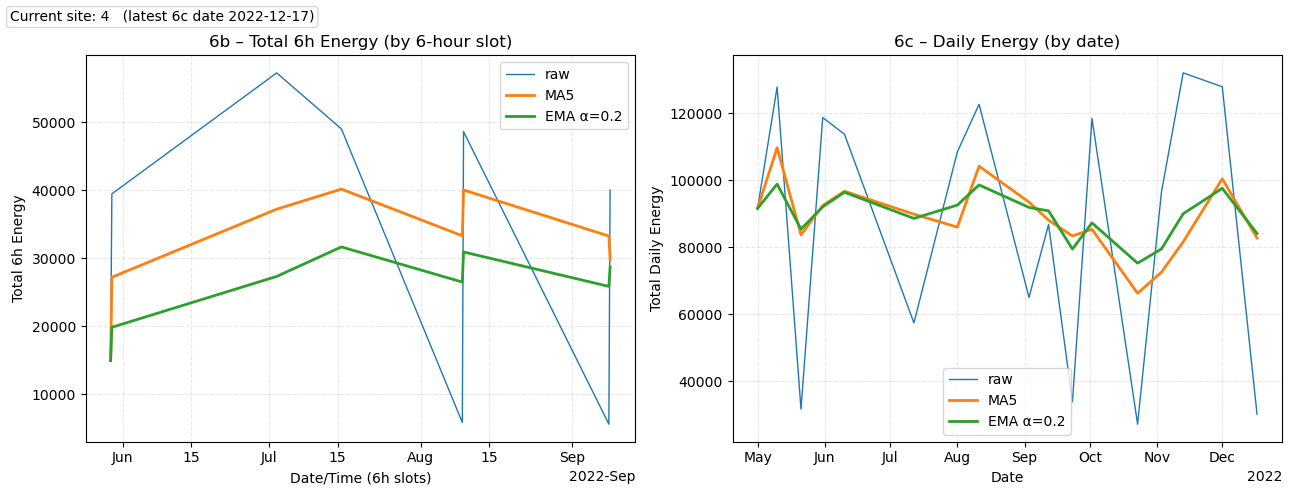

In [49]:
# === REAL-TIME LINE DASHBOARD (6b uses date+slot -> hourly x-axis; 6c uses date)
#     + figure-level "Current site" label derived from latest 6c CSV ===
from IPython.display import clear_output
from collections import deque
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import time

CSV_6B = Path("/tmp/plots/latest_6b.csv")   # expects: date,slot,energy_6h_total
CSV_6C = Path("/tmp/plots/latest_6c.csv")   # expects: site_id,date,daily_energy

POLL_SECS   = 5
ITERATIONS  = 60
MAX_POINTS  = 240
MA_WINDOW   = 5
EMA_ALPHA   = 0.2

# 6b keeps one point per 6h window; 6c keeps one point per date
history_6b = deque(maxlen=MAX_POINTS)   # (ts, value) where ts = date + slot*6h
history_6c = deque(maxlen=MAX_POINTS)   # (date_norm, value)
seen_ts_6b  = set()
seen_dates_6c = set()

def try_read(csv_path: Path):
    try:
        if csv_path.exists() and csv_path.stat().st_size > 0:
            return pd.read_csv(csv_path)
    except Exception:
        pass
    return None

def moving_average(values, window):
    if window <= 1 or len(values) == 0:
        return values
    out, s = [], 0.0
    for i, v in enumerate(values):
        s += v
        if i >= window:
            s -= values[i - window]
        out.append(s / min(i + 1, window))
    return out

def ema(values, alpha=0.2):
    if not values:
        return values
    out = [values[0]]
    for v in values[1:]:
        out.append(alpha * v + (1 - alpha) * out[-1])
    return out

# ---- 6b: date+slot -> timestamp at the slot start (use +3h for midpoint if you prefer) ----
def append_new_points_6b(history, seen_ts, df):
    if df is None or df.empty:
        return
    needed = {"date","slot","energy_6h_total"}
    if not needed.issubset(df.columns):
        return

    pdf = df.copy()
    pdf["date"] = pd.to_datetime(pdf["date"], errors="coerce")
    pdf["slot"] = pd.to_numeric(pdf["slot"], errors="coerce")
    pdf["energy_6h_total"] = pd.to_numeric(pdf["energy_6h_total"], errors="coerce")
    pdf = pdf.dropna(subset=["date","slot","energy_6h_total"])

    pdf["ts"] = pdf["date"] + pd.to_timedelta(pdf["slot"] * 6, unit="h")
    sixh = (pdf.groupby("ts", as_index=False)["energy_6h_total"]
               .sum()
               .sort_values("ts"))
    for _, row in sixh.iterrows():
        ts = pd.Timestamp(row["ts"])
        val = float(row["energy_6h_total"])
        if ts not in seen_ts:
            seen_ts.add(ts)
            history.append((ts, val))

# ---- 6c: group by normalized date ----
def append_new_points_6c(history, seen_dates, df):
    if df is None or df.empty or not {"date","daily_energy"}.issubset(df.columns):
        return
    pdf = df.copy()
    pdf["date"] = pd.to_datetime(pdf["date"], errors="coerce")
    pdf["daily_energy"] = pd.to_numeric(pdf["daily_energy"], errors="coerce")
    pdf = pdf.dropna(subset=["date","daily_energy"])
    pdf["date_norm"] = pdf["date"].dt.normalize()
    daily = (pdf.groupby("date_norm", as_index=False)["daily_energy"]
               .sum()
               .sort_values("date_norm"))
    for _, row in daily.iterrows():
        d = pd.Timestamp(row["date_norm"])
        v = float(row["daily_energy"])
        if d not in seen_dates:
            seen_dates.add(d)
            history.append((d, v))

# ---- Compute the figure-level label: "Current site: <id> (latest 6c date <YYYY-MM-DD>)" ----
def current_site_label(pdf_c):
    if pdf_c is None or pdf_c.empty or not {"site_id","date","daily_energy"}.issubset(pdf_c.columns):
        return None
    tmp = pdf_c.copy()
    tmp["date"] = pd.to_datetime(tmp["date"], errors="coerce")
    tmp["daily_energy"] = pd.to_numeric(tmp["daily_energy"], errors="coerce")
    tmp = tmp.dropna(subset=["date","daily_energy"])
    if tmp.empty:
        return None
    latest_date = tmp["date"].max()
    day = tmp[tmp["date"] == latest_date]
    if day.empty:
        return None
    # pick the top site by daily_energy on the latest date
    top = day.sort_values("daily_energy", ascending=False).head(1)
    sid = int(top["site_id"].iloc[0])
    dstr = latest_date.strftime("%Y-%m-%d")
    return f"Current site: {sid}   (latest 6c date {dstr})"

# ---------- Main loop ----------
for _ in range(ITERATIONS):
    pdf_b = try_read(CSV_6B)
    pdf_c = try_read(CSV_6C)

    append_new_points_6b(history_6b, seen_ts_6b, pdf_b)
    append_new_points_6c(history_6c, seen_dates_6c, pdf_c)

    site_note = current_site_label(pdf_c)

    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=False)

    # Add a non-overlapping figure-level label (top-left)
    if site_note:
        fig.text(
            0.01, 0.98, site_note,
            ha="left", va="top",
            bbox=dict(facecolor="white", alpha=0.9, edgecolor="lightgray", boxstyle="round,pad=0.25")
        )

    # --- 6b: X = date + slot*6h (hours & days) ---
    if history_6b:
        xb, yb = zip(*sorted(history_6b, key=lambda t: t[0]))
        yb_ma, yb_ema = moving_average(list(yb), MA_WINDOW), ema(list(yb), EMA_ALPHA)
        axes[0].plot(xb, yb, linewidth=1, label="raw")
        axes[0].plot(xb, yb_ma, linewidth=2, label=f"MA{MA_WINDOW}")
        axes[0].plot(xb, yb_ema, linewidth=2, label=f"EMA α={EMA_ALPHA}")
        axes[0].set_title("6b – Total 6h Energy (by 6-hour slot)")
        axes[0].set_xlabel("Date/Time (6h slots)")
        axes[0].set_ylabel("Total 6h Energy")
        axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
        axes[0].xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(axes[0].xaxis.get_major_locator())
        )
        axes[0].grid(True, linestyle="--", alpha=0.3)
        axes[0].legend(loc="best")
    else:
        axes[0].text(0.5, 0.5, "Waiting for 6b data...", ha='center', va='center')
        axes[0].set_axis_off()

    # --- 6c: X = date only (daily) ---
    if history_6c:
        xc, yc = zip(*sorted(history_6c, key=lambda t: t[0]))
        yc_ma, yc_ema = moving_average(list(yc), MA_WINDOW), ema(list(yc), EMA_ALPHA)
        axes[1].plot(xc, yc, linewidth=1, label="raw")
        axes[1].plot(xc, yc_ma, linewidth=2, label=f"MA{MA_WINDOW}")
        axes[1].plot(xc, yc_ema, linewidth=2, label=f"EMA α={EMA_ALPHA}")
        axes[1].set_title("6c – Daily Energy (by date)")
        axes[1].set_xlabel("Date")
        axes[1].set_ylabel("Total Daily Energy")
        axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
        axes[1].xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(axes[1].xaxis.get_major_locator())
        )
        axes[1].grid(True, linestyle="--", alpha=0.3)
        axes[1].legend(loc="best")
    else:
        axes[1].text(0.5, 0.5, "Waiting for 6c data...", ha='center', va='center')
        axes[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for the top label
    plt.show()
    time.sleep(POLL_SECS)


In [50]:
for q in spark.streams.active: q.stop()

In [51]:
spark.sparkContext.cancelAllJobs()

In [52]:
for q in spark.streams.active:
    print("Stopping:", q.name or q.id)
    q.stop()


In [53]:
spark.sparkContext.cancelAllJobs()
for q in spark.streams.active:
    try:
        q.stop()
    except Exception as e:
        print("Force stop failed:", e)

3.	Plot a diagram to visualise the daily shortfall/excess energy in each site. The shortfall/excess energy is defined as the predicted total sum of energy in each site, minus the metered data (the value can be positive or negative, depending on the model and data quality).

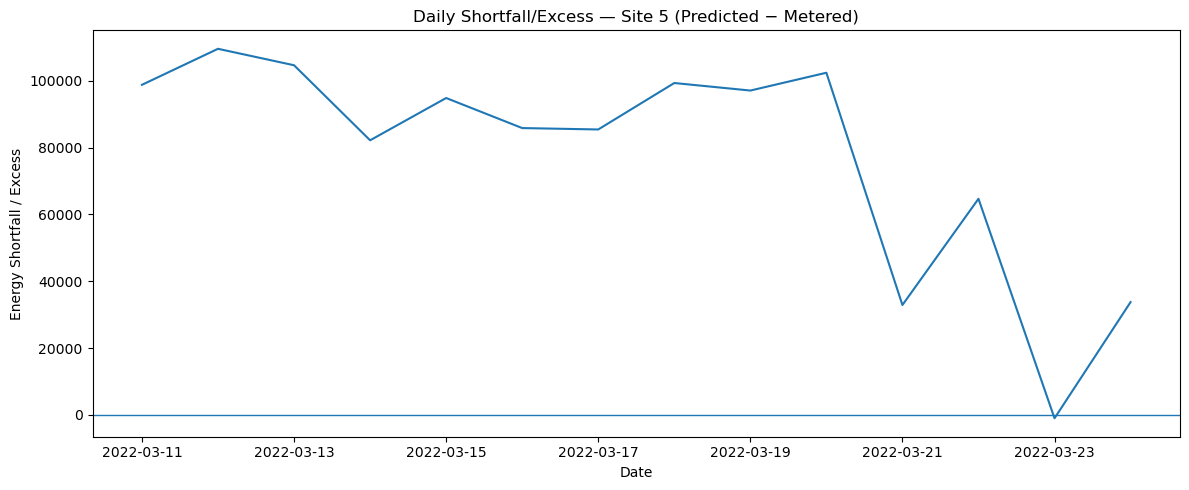

[batch 4] single-site plot updated (site 5, last 14 days).
[batch 4] saved PNG: /tmp/plots_shortfall_snapshots/site_5_2022-03-24.png


In [54]:
# ============================
# Daily Shortfall/Excess Visualisation (Predicted − Metered) — PySpark-first
# - Spark for all ETL/joins/aggregations
# - Minimal Python (lists) only for plotting
# - Keeps last N days per-site in driver memory (no pandas needed)
# ============================

# 0) Matplotlib cache fix (must be above pyplot import)
import os
os.environ["MPLCONFIGDIR"] = "/tmp/mpl"
os.makedirs("/tmp/mpl", exist_ok=True)

from pyspark.sql import functions as F, types as T
from IPython.display import clear_output
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
STARTING_OFFSETS = "latest"  # set to "earliest" once to replay the topic
CKPT_DIR = "/tmp/stream_jobs/ckpt/shortfall_plot_pyspark01"
LAST_N_DAYS = 14     # window for single-site plot
PRED_TOPIC = "energy_daily_by_site"
SNAP_DIR = "/tmp/plots_shortfall_snapshots"; os.makedirs(SNAP_DIR, exist_ok=True)

# (optional) filter specific sites at ingestion time
TARGET_SITES = None  # e.g., [4] or None for all

# ---------- 1) Build METERS (site × day, ALL meter types) ----------
# meters_with_site columns: building_id:int, meter_type:str, ts:timestamp, value:double, row_id:int, site_id:int
METERS = (
    meters_with_site
      .withColumn("date", F.to_date("ts"))
      .groupBy("site_id", "date")
      .agg(F.sum("value").alias("daily_metered"))
      .select(F.col("site_id").cast("int").alias("site_id"),
              F.col("date"),
              F.col("daily_metered").cast("double").alias("daily_metered"))
      .cache()
)
print("✅ METERS (site×day, all types) ready:", METERS.count(), "rows")
METERS.orderBy("site_id","date").show(5, truncate=False)

# ---------- 2) Read predictions (site × day) from Kafka ----------
pred_schema = T.StructType([
    T.StructField("site_id",      T.IntegerType()),
    T.StructField("date",         T.StringType()),   # will cast to date
    T.StructField("daily_energy", T.DoubleType()),
])

predictions_raw = (
    spark.readStream.format("kafka")
         .option("kafka.bootstrap.servers", KAFKA_BOOTSTRAP)
         .option("subscribe", PRED_TOPIC)
         .option("startingOffsets", STARTING_OFFSETS)
         .load()
         .select(F.from_json(F.col("value").cast("string"), pred_schema).alias("v"))
         .select("v.*")
         .withColumn("site_id", F.col("site_id").cast("int"))
         .withColumn("date",    F.to_date("date"))
         .withColumn("daily_energy", F.col("daily_energy").cast("double"))
         .dropna(subset=["site_id","date","daily_energy"])
)

if TARGET_SITES:
    predictions_raw = predictions_raw.where(F.col("site_id").isin(TARGET_SITES))

# ---------- 3) Plotter: all Spark ops inside foreachBatch ----------
# In-memory rolling history: { site_id: {date: shortfall, ...}, ... }
_HISTORY = {}

def plot_shortfall(batch_df, batch_id: int):
    if batch_df.rdd.isEmpty():
        print(f"[batch {batch_id}] empty micro-batch"); return

    # Collapse to site×day (Spark)
    pred_site_day = (batch_df
                     .groupBy("site_id","date")
                     .agg(F.sum("daily_energy").alias("daily_predicted")))

    # Exact-date join (Spark)
    joined = (pred_site_day.alias("p")
              .join(F.broadcast(METERS).alias("m"), on=["site_id","date"], how="inner")
              .select("site_id","date",
                      F.col("daily_predicted"),
                      F.col("daily_metered"),
                      (F.col("daily_predicted") - F.col("daily_metered")).alias("shortfall")))

    # If no rows, try ±1 day alignment (Spark)
    if joined.rdd.isEmpty():
        j_plus = (pred_site_day.alias("p")
                  .join(F.broadcast(METERS).withColumn("date", F.date_add(F.col("date"), 1)).alias("m"),
                        on=["site_id","date"], how="inner")
                  .select("site_id","date",
                          F.col("daily_predicted"),
                          F.col("daily_metered"),
                          (F.col("daily_predicted") - F.col("daily_metered")).alias("shortfall")))
        j_minus = (pred_site_day.alias("p")
                   .join(F.broadcast(METERS).withColumn("date", F.date_add(F.col("date"), -1)).alias("m"),
                         on=["site_id","date"], how="inner")
                   .select("site_id","date",
                           F.col("daily_predicted"),
                           F.col("daily_metered"),
                           (F.col("daily_predicted") - F.col("daily_metered")).alias("shortfall")))

        c_plus = j_plus.count()
        c_minus = j_minus.count()
        if c_plus == 0 and c_minus == 0:
            print(f"[batch {batch_id}] no overlap (exact/+1/-1); nothing to plot"); return
        joined = j_plus if c_plus >= c_minus else j_minus
        print(f"[batch {batch_id}] used {'+1d' if c_plus >= c_minus else '-1d'} alignment")

    # Decide plotting mode
    sites = [r.site_id for r in joined.select("site_id").distinct().collect()]
    if len(sites) == 1:
        # ----- Single-site time series -----
        site_id_val = sites[0]
        rows = (joined
                .select("date","shortfall")
                .orderBy("date")
                .collect())

        # Update in-memory history for this site (dict of {date: shortfall})
        h = _HISTORY.get(site_id_val, {})
        for r in rows:
            # r.date is a datetime.date; safe to use as dict key
            h[r["date"]] = float(r["shortfall"]) if r["shortfall"] is not None else 0.0
        _HISTORY[site_id_val] = h

        # Build last N days window from history (sorted by date)
        all_dates_sorted = sorted(h.keys())
        tail_dates = all_dates_sorted[-LAST_N_DAYS:]
        x_dates = tail_dates
        y_vals  = [h[d] for d in tail_dates]

        if not x_dates:
            print(f"[batch {batch_id}] no data to plot for site {site_id_val}"); return

        # Plot
        clear_output(wait=True)
        plt.figure(figsize=(12,5))
        plt.plot(x_dates, y_vals)
        plt.axhline(0, linewidth=1)
        plt.title(f"Daily Shortfall/Excess — Site {site_id_val} (Predicted − Metered)")
        plt.xlabel("Date"); plt.ylabel("Energy Shortfall / Excess")
        plt.tight_layout(); plt.show(); plt.close()

        # Optional PNG snapshot
        last_str = x_dates[-1].isoformat()
        png_path = os.path.join(SNAP_DIR, f"site_{site_id_val}_{last_str}.png")
        plt.figure(figsize=(12,5))
        plt.plot(x_dates, y_vals)
        plt.axhline(0, linewidth=1)
        plt.title(f"Daily Shortfall/Excess — Site {site_id_val} (Predicted − Metered)")
        plt.xlabel("Date"); plt.ylabel("Energy Shortfall / Excess")
        plt.tight_layout(); plt.savefig(png_path, dpi=150, bbox_inches="tight"); plt.close()
        print(f"[batch {batch_id}] single-site plot updated (site {site_id_val}, last {len(x_dates)} days).")
        print(f"[batch {batch_id}] saved PNG: {png_path}")
        return

    # ----- Multi-site: bar for latest date in this batch -----
    latest_date = joined.agg(F.max("date").alias("d")).first()["d"]
    latest_df = joined.where(F.col("date") == F.lit(latest_date))
    site_shortfalls = [(r["site_id"], float(r["shortfall"]) if r["shortfall"] is not None else 0.0)
                       for r in latest_df.select("site_id","shortfall").orderBy("shortfall").collect()]

    if not site_shortfalls:
        print(f"[batch {batch_id}] nothing to plot on {latest_date}"); return

    xs = list(range(len(site_shortfalls)))
    ys = [v for _, v in site_shortfalls]
    labels = [str(s) for s, _ in site_shortfalls]

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.bar(xs, ys)
    plt.axhline(0, linewidth=1)
    plt.xticks(xs, labels)
    plt.title(f"Daily Shortfall/Excess by Site — {latest_date} (Predicted − Metered)")
    plt.xlabel("Site ID"); plt.ylabel("Energy Shortfall / Excess")
    plt.tight_layout(); plt.show(); plt.close()

    out_csv = os.path.join(SNAP_DIR, f"shortfall_sites_{str(latest_date)}.csv")
    # quick CSV with Python (no pandas)
    with open(out_csv, "w") as f:
        f.write("site_id,shortfall\n")
        for s, v in site_shortfalls:
            f.write(f"{s},{v}\n")
    print(f"[batch {batch_id}] multi-site bar saved: {out_csv}")

# ---------- 4) Start streaming (no stateful ops in the plan) ----------
try:
    q_shortfall.stop()
except:
    pass

q_shortfall = (
    predictions_raw
      .writeStream
      .foreachBatch(plot_shortfall)
      .option("checkpointLocation", CKPT_DIR)
      .outputMode("append")                 # logic is inside foreachBatch
      .trigger(processingTime="5 seconds")  # regular ticks
      .start()
)

print("▶️ Shortfall/excess visualisation started.")
print(f"   - Single-site: time-series (last {LAST_N_DAYS} days, driver-memory history).")
print("   - Multi-site:  bar chart for latest day in each micro-batch.")
print("   Stop with: q_shortfall.stop()")


In [55]:
q_shortfall.stop()

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/sql/utils.py", line 120, in call
    raise e
  File "/opt/conda/lib/python3.10/site-packages/pyspark/sql/utils.py", line 117, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/tmp/ipykernel_85/2818885314.py", line 112, in plot_shortfall
    sites = [r.site_id for r in joined.select("site_id").distinct().collect()]
  File "/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py", line 1257, in collect
    sock_info = self._jdf.collectToPython()
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1322, in __call__
    return_value = get_return_value(
  File "/opt/conda/lib/python3.10/

In [ ]:
print("status:", q_shortfall.status)
print("lastProgress:", q_shortfall.lastProgress)
print("recentProgress (len):", len(q_shortfall.recentProgress))
for i, p in enumerate(q_shortfall.recentProgress[-5:], 1):
    print(f"progress[-{i}]:", p.get("batchId"), p.get("numInputRows"), p.get("sources"))
